# Steady as she goes
> A common talking point on Twitter is that LUNA is resistant to broader market downturns, when compared to other leading cryptocurrencies.

- toc: false 
- badges: true
- comments: true
- categories: [terra, flipside, crypto]
- image: images/terra.jpg
- hide_binder_badge: true
- hide_deepnote_badge: true
- hide: true
- search_exclude: false
- permalink: /steady-as-she-goes/

In [1]:
#hide
!pip install yfinance arch

     |████████████████████████████████| 902 kB 7.5 MB/s 
     |████████████████████████████████| 6.4 MB 41.8 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 9.8 MB 20.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10

### LUNA Stability

Crypto market is believed to be volatile compared to most of the well known financial instruments. Although the returns are high, many of the high net worth investors and institutional investors are bit hesitant to enter the market due to that risk. However, it's been quite clear that since late even those institutional investors with low risk apetite has also started investing in crypto currencies specially in Bitcoin. As the oldest and the first crypto currency, Bitcoin still maintains the number one crypto asset in terms of market cap and potentially the familiarity and popularity among the general public.

Terra started making headlines in crypto world with the goal of making algorthmic decentralized stable coins. LUNA is the life blood of Terra eco system which acts as The Terra protocol’s native staking token that absorbs the price volatility of Terra. Luna is used for governance and in mining. Users stake Luna to validators who record and verify transactions on the blockchain in exchange for rewards from transaction fees. The more Terra is used, the more Luna is worth.

In order to understand how stable LUNA is, We will compare it with BTC first and then ETH, and ADA, the reason is BTC is the coin that anybody would like to compare against, ETH is the second largest market cap coin while it's also the first coin with smart contracts, while ADA is a coin with a similar market cap of LUNA while older than LUNA. So in comparing one to another in the worst market times we will be looking at the price volatility of these underlying assets. first compare LUNA with BTC price volatility since the beginning of 2021, and we will then be look at all the 4 assets mentioned above during the recent market down turn.



In [2]:
# hide
import yfinance as yf
import pandas as pd
import numpy as np
import math
from arch import arch_model
from arch.__future__ import reindexing

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams, style, ticker
import matplotlib.dates as mdates
from matplotlib.transforms import Bbox

from urllib.request import urlopen
import json
from datetime import date, datetime

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
#hide
pd.set_option('display.float_format', lambda x: '%.5f' % x)
sns.set_context('poster')
style.use('seaborn-poster')
sns.set_theme(style="darkgrid")
rcParams['font.family'] = "serif"

In [4]:
#hide
def load_data_from_flipside(url:str) -> pd.DataFrame:
    response = urlopen(url)
    json_data = response.read().decode('utf-8', 'replace')
    d = json.loads(json_data)
    return pd.json_normalize(d)

In [5]:
#hide
def show_fig(ax, x_label, y_label):
  fig = plt.gcf()
  fig.set_size_inches(21, 10.5)
  plt.xticks(rotation=45, ha='right')
  plt.xlabel(x_label, fontsize=26)
  plt.ylabel(y_label, fontsize=26)
  plt.tick_params(labelsize=18)
  plt.legend(title="Price in USD", bbox_to_anchor=(1.01, 1), loc=2)
  plt.setp(ax.get_legend().get_texts(), fontsize='22')
  plt.setp(ax.get_legend().get_title(), fontsize='24')
  plt.show()

In [6]:
#hide
price_api_url = "https://api.flipsidecrypto.com/api/v2/queries/233461f1-651f-4b9e-9f13-e0e0de7e5e4f/data/latest"
flp_price_df = load_data_from_flipside(price_api_url)
flp_price_df.rename(columns={"LUNA_PRICE" : "LUNA", "ETH_PRICE" : "ETH", "BTC_PRICE" : "BTC", "DATETIME" : "Datetime"}, inplace=True)

In [7]:
#hide
tickers = ["ADA-USD"]
yf_dfs = []

for ticker in tickers:
    data = yf.download(ticker, interval="60m", start="2021-01-01", end="2022-03-01")
    data['ticker'] = ticker
    yf_dfs.append(data)

yf_df = pd.concat(yf_dfs)
yf_df = yf_df.reset_index()

[*********************100%***********************]  1 of 1 completed


In [8]:
#hide
flp_price_df.Datetime = pd.to_datetime(flp_price_df.Datetime)
flp_price_df = flp_price_df.set_index("Datetime")

In [9]:
#hide
yf_df = yf_df[['Datetime', 'Close', 'ticker']]
yf_df.Datetime = pd.to_datetime(yf_df.Datetime, format="%Y-%m-%d %H:%M:%S").dt.tz_convert(None)

In [10]:
#hide
grouper = yf_df.groupby('ticker')
df = pd.concat([pd.Series(v['Close'].tolist(), name=k, index=v['Datetime'].tolist()) for k, v in grouper], axis=1)

df = df.rename(columns={"ADA-USD" : "ADA"})
dataframe = pd.concat([flp_price_df, df], axis=1, join='inner')

for col in dataframe.columns:
    dataframe[f'{col}_1d_rolling'] = np.log(dataframe[col]).rolling(24).std()
    dataframe[f'{col}_hourly_Return'] = 100 * (dataframe[col].pct_change())
    dataframe[f'{col}_hourly_log_Return'] = 100 * (np.log(dataframe[col]).pct_change())
    dataframe[f'{col}_Return'] = 100 * (dataframe[col].rolling(24).mean().pct_change())

#### Price change percentages

First We have hourly price changes of LUNA and BTC thanks to flipside crypto and yahoo finance. Let's look at BTC and LUNA price change percentage over 24 hour rolling average since the beginning of 2021. 

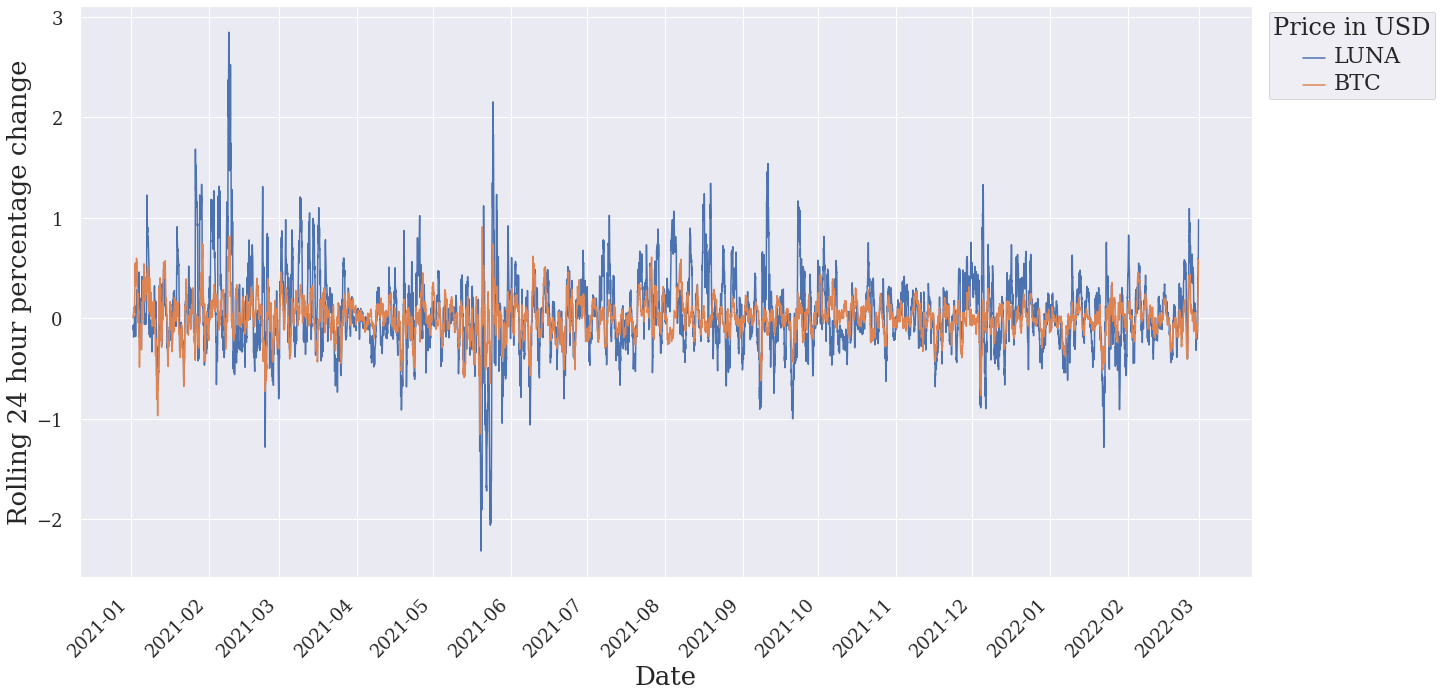

In [11]:
#hide_input
ax = sns.lineplot(x=dataframe.index, y=dataframe.LUNA_Return, label="LUNA")
sns.lineplot(x=dataframe.index, y=dataframe.BTC_Return, ax=ax, label="BTC")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))

show_fig(ax, "Date", "Rolling 24 hour percentage change")

Now it's evident that BTC had days with more than 2% change in 24 hour moving averages in to the downside than LUNA while LUNA sees more fluctuation in price both down and up wards than BTC.

First Let's do the same comparison with ETH and ADA... 

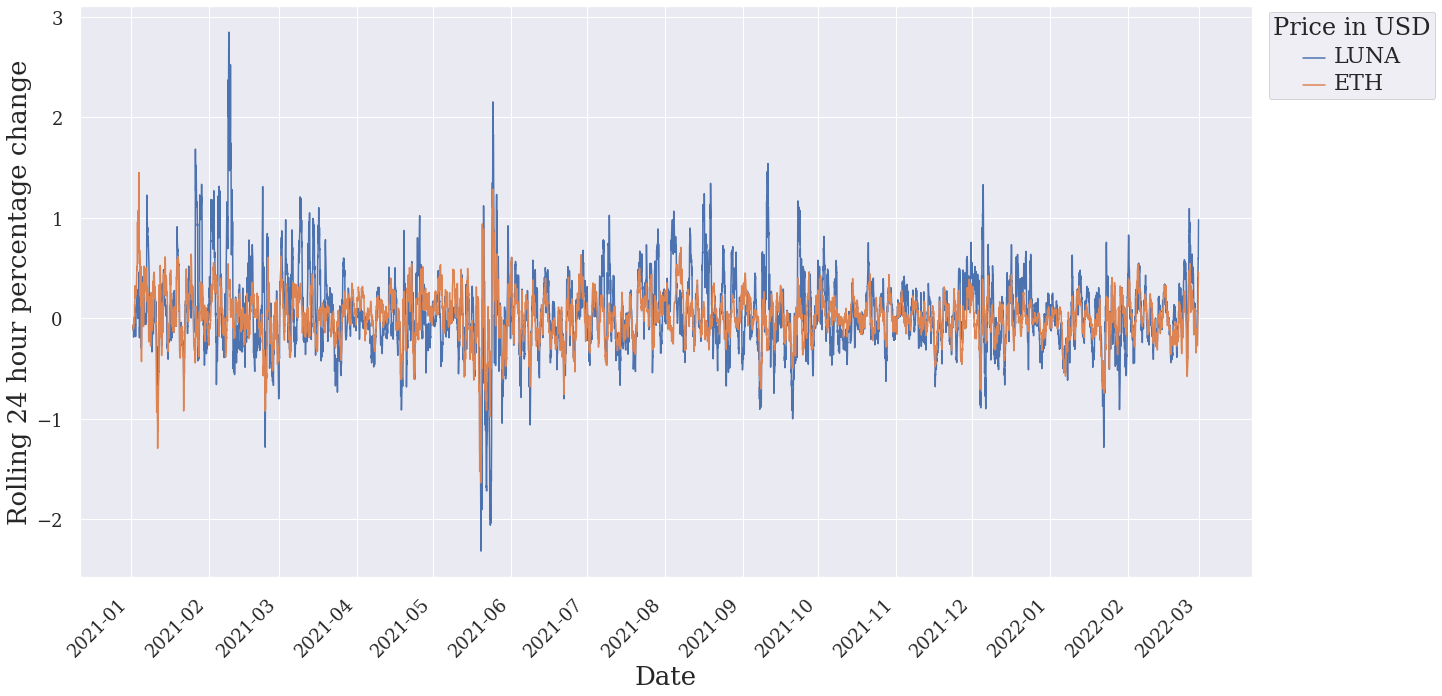

In [12]:
#hide_input
ax = sns.lineplot(x=dataframe.index, y=dataframe.LUNA_Return, label="LUNA")
sns.lineplot(x=dataframe.index, y=dataframe.ETH_Return, ax=ax, label="ETH")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))

show_fig(ax, "Date", "Rolling 24 hour percentage change")

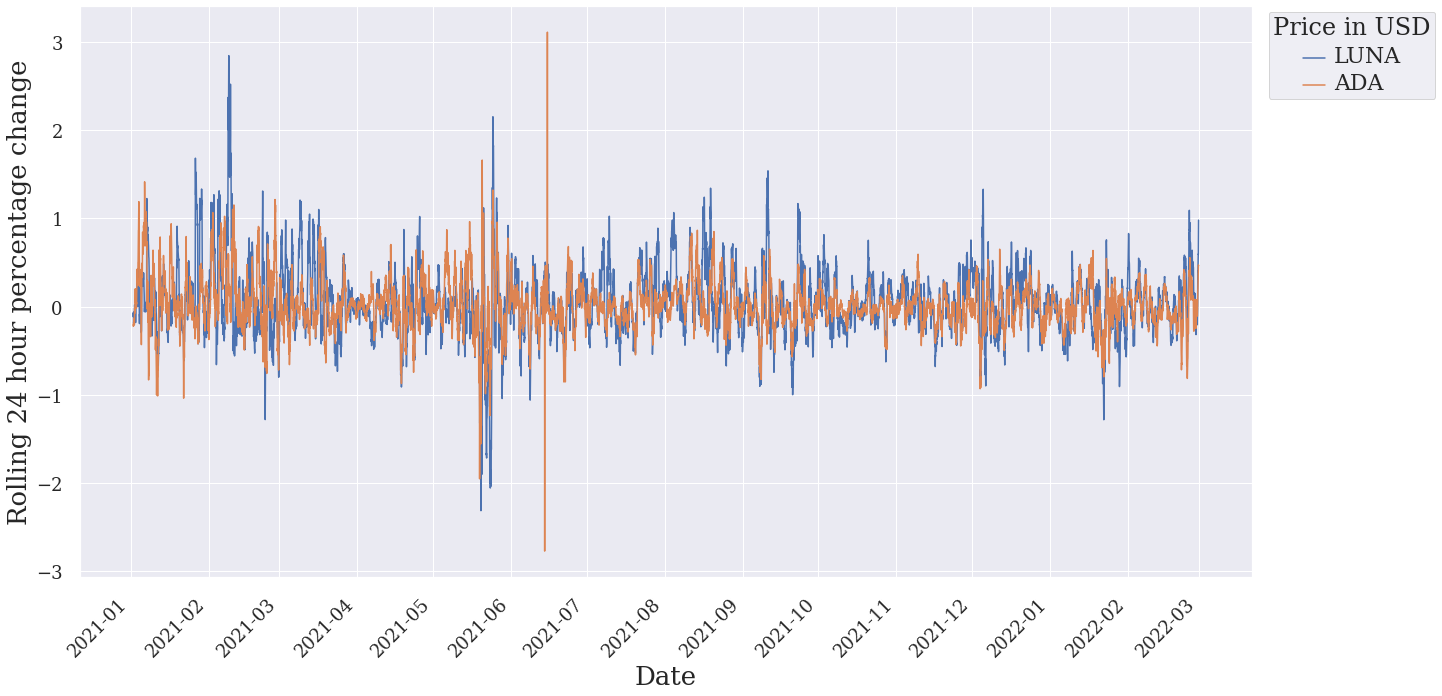

In [13]:
#hide_input
ax = sns.lineplot(x=dataframe.index, y=dataframe.LUNA_Return, label="LUNA")
sns.lineplot(x=dataframe.index, y=dataframe.ADA_Return, ax=ax, label="ADA")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))

show_fig(ax, "Date", "Rolling 24 hour percentage change")

Just by looking at the charts we can guess that ADA was more volatile in price while ETH was slightly better performing than LUNA, but was that true? let's look at the standard deviation on a 24 hour rolling basis to get a different view.


#### What is moving standard deviation

Moving Standard Deviation is a statistical measurement of market volatility. It makes no predictions of market direction, but it may serve as a confirming indicator. You specify the number of periods to use, and the study computes the standard deviation of prices from the moving average of the prices.

Standard Deviation values rise significantly when the analyzed contract of indicator change in value dramatically. When markets are stable, low Standard Deviation readings are normal.



In the following graph we will be comparing 24 hour rolling standard deviation of the 4 assets mentioned above. The size of the data point represents the price of the underlying assts. bigger the point higher the price.

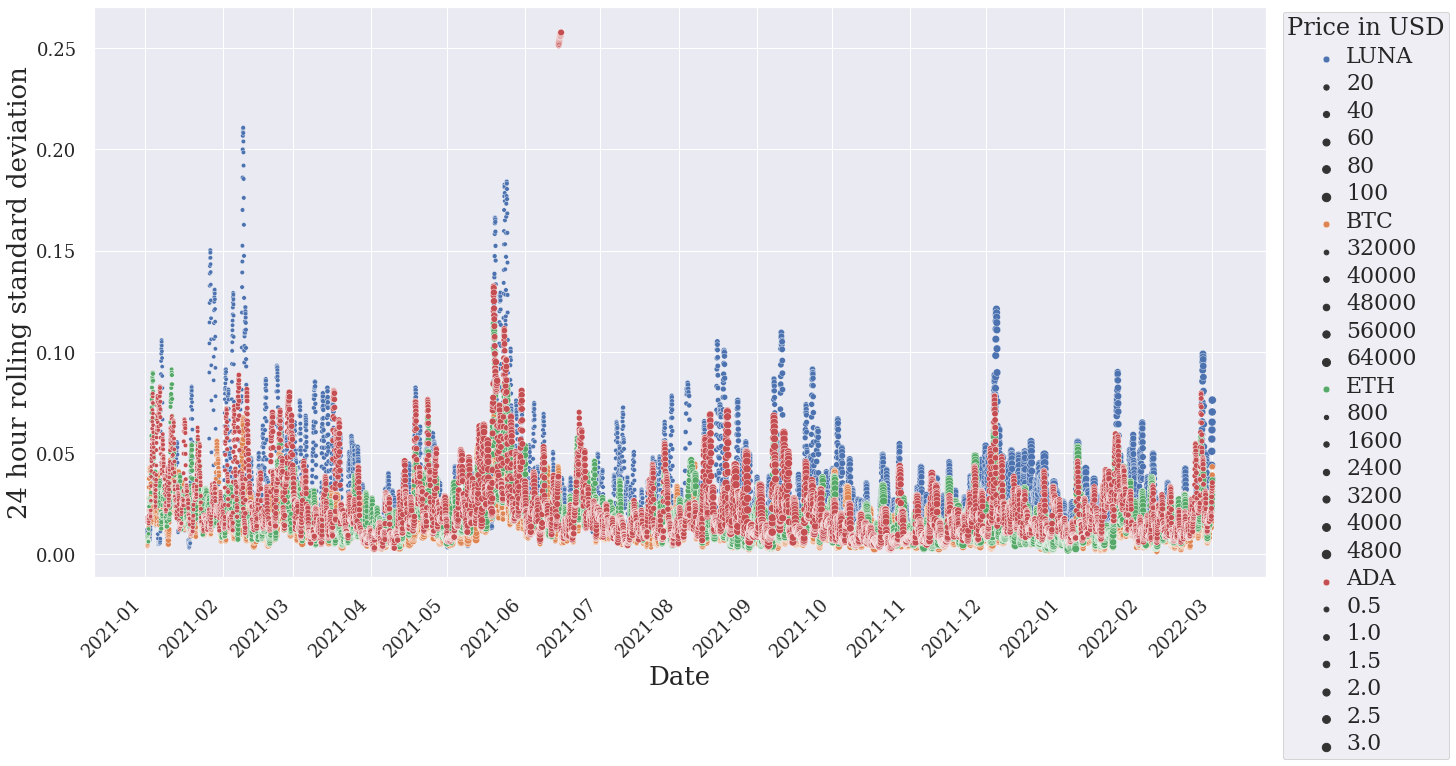

In [14]:
#hide_input
ax = sns.scatterplot(x=dataframe.index, y=dataframe.LUNA_1d_rolling, size=dataframe.LUNA, label="LUNA")
sns.scatterplot(x=dataframe.index, y=dataframe.BTC_1d_rolling, size=dataframe.BTC, ax=ax, label="BTC")
sns.scatterplot(x=dataframe.index, y=dataframe.ETH_1d_rolling, size=dataframe.ETH, ax=ax, label="ETH")
sns.scatterplot(x=dataframe.index, y=dataframe.ADA_1d_rolling, size=dataframe.ADA, ax=ax, label="ADA")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))

show_fig(ax, "Date", "24 hour rolling standard deviation")

It looks like LUNA had it's fair share of volatility specially when the price was low and with price getting higher and higher it's volatility has been reduced somewhat. Now how can we quantify this and compare the volatility in a better way.

In [15]:
#hide
volatility_df = pd.DataFrame(index=["BTC", "LUNA", "ETH", "ADA"], columns=["Hourly", "Daily", "Annual"])

hourly_volatility_luna = dataframe['LUNA_hourly_Return'].std()
volatility_df.loc[volatility_df.index == "LUNA", "Hourly"] = hourly_volatility_luna
# print('LUNA Hourly volatility: ', '{:.2f}%'.format(hourly_volatility_luna))

daily_volatility_luna = math.sqrt(24) * hourly_volatility_luna
volatility_df.loc[volatility_df.index == "LUNA", "Daily"] = daily_volatility_luna
# print ('LUNA Daily volatility: ', '{:.2f}%'.format(daily_volatility_luna))

annual_volatility_luna = math.sqrt(24*365.25) * hourly_volatility_luna
volatility_df.loc[volatility_df.index == "LUNA", "Annual"] = annual_volatility_luna
# print ('LUNA Annual volatility: ', '{:.2f}%'.format(annual_volatility_luna))

hourly_volatility_eth = dataframe['ETH_Return'].std()
volatility_df.loc[volatility_df.index == "ETH", "Hourly"] = hourly_volatility_eth
# print('ETH Hourly volatility: ', '{:.2f}%'.format(hourly_volatility_eth))

daily_volatility_eth = math.sqrt(24) * hourly_volatility_eth
volatility_df.loc[volatility_df.index == "ETH", "Daily"] = daily_volatility_eth
# print ('ETH Daily volatility: ', '{:.2f}%'.format(daily_volatility_eth))

annual_volatility_eth = math.sqrt(24*365.25) * hourly_volatility_eth
volatility_df.loc[volatility_df.index == "ETH", "Annual"] = annual_volatility_eth
# print ('ETH Annual volatility: ', '{:.2f}%'.format(annual_volatility_eth))

hourly_volatility_btc = dataframe['BTC_Return'].std()
volatility_df.loc[volatility_df.index == "BTC", "Hourly"] = hourly_volatility_btc
# print('BTC Hourly volatility: ', '{:.2f}%'.format(hourly_volatility_btc))

daily_volatility_btc = math.sqrt(24) * hourly_volatility_btc
volatility_df.loc[volatility_df.index == "BTC", "Daily"] = daily_volatility_btc
# print ('BTC Daily volatility: ', '{:.2f}%'.format(daily_volatility_btc))

annual_volatility_btc = math.sqrt(24*365.25) * hourly_volatility_btc
volatility_df.loc[volatility_df.index == "BTC", "Annual"] = annual_volatility_btc
# print ('BTC Annual volatility: ', '{:.2f}%'.format(annual_volatility_btc))

hourly_volatility_ada = dataframe['ADA_Return'].std()
volatility_df.loc[volatility_df.index == "ADA", "Hourly"] = hourly_volatility_ada
# print('ADA Hourly volatility: ', '{:.2f}%'.format(hourly_volatility_ada))

daily_volatility_ada = math.sqrt(24) * hourly_volatility_ada
volatility_df.loc[volatility_df.index == "ADA", "Daily"] = daily_volatility_ada
# print ('ADA Daily volatility: ', '{:.2f}%'.format(daily_volatility_ada))

annual_volatility_ada = math.sqrt(24*365.25) * hourly_volatility_ada
volatility_df.loc[volatility_df.index == "ADA", "Annual"] = annual_volatility_ada
# print ('ADA Annual volatility: ', '{:.2f}%'.format(annual_volatility_ada))

In [16]:
#hide_input
volatility_df

,Hourly,Daily,Annual
BTC,0.17935,0.87861,16.79153
LUNA,1.61820,7.92752,151.50690
ETH,0.22908,1.12224,21.44778
ADA,0.27858,1.36478,26.08300


This is the daily, weekly and annualized volatility for the 4 assets we were comparing. Now these numbers are for data from the beginning of 2021 although this shows LUNA was highly volatile compared to other assets we know the price of the LUNA was also changed 127X during the time period. We'll look at how these 4 assets performed suring the recent market downturn in early 2022 but before that let's try to get an intuition of this volatility bit further. for that we will be using a [GARCH model](https://www.sciencedirect.com/science/article/abs/pii/0304407686900631?via%3Dihub)

# What is a GARCH model.

Generalized AutoRegressive Conditional Heteroskedasticity (GARCH) is a statistical model used in analyzing time-series data where the variance error is believed to be serially autocorrelated. GARCH models assume that the variance of the error term follows an autoregressive moving average process.

which means it suited for:
- predicting the volatility of returns on financial assets.
- assessing risk and expected returns for assets that exhibit clustered periods of volatility in returns.


In [17]:
#hide
list_results = []
garch_model = arch_model(dataframe['LUNA_hourly_Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
list_results.append(gm_result.params.rename("LUNA"))

garch_model = arch_model(dataframe['ETH_hourly_Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
list_results.append(gm_result.params.rename("ETH"))

garch_model = arch_model(dataframe['BTC_hourly_Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
list_results.append(gm_result.params.rename("BTC"))

garch_model = arch_model(dataframe['ADA_hourly_Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
list_results.append(gm_result.params.rename("ADA"))

In [18]:
#hide_input
pd.concat(list_results, axis=1)

,LUNA,ETH,BTC,ADA
mu,0.02505,0.03036,0.01295,-0.03378
omega,0.08298,0.03130,0.07397,0.04282
alpha[1],0.14766,0.11922,0.28779,0.09479
beta[1],0.83199,0.85102,0.62388,0.90521


No how can we interpret this:

Alpha (ARCH term) represents how volatility reacts to new information(small alpha=small impact of innovation) Beta (GARCH Term) represents persistence of the volatility Alpha + Beta shows overall measurement of persistence of volatility. in each case we obtained a model with small alpha and high beta. Alpha catches the effect of innovations on future volatility, while (alpha+beta) - how long the effect persist (or how fast it decays over time). In each of these models alpha+beta is high, so the effect decays slowly.

So what we can say about the 4 assets?

LUNA's volatility is the most impacted in short term while it's volatility persistent is the lowest on the other hand BTC's sudden volatility impact is lowest compared to other 3 but the persistence of the volatility is highest among all.

In [19]:
#hide_input
pd.DataFrame(100 * (dataframe.iloc[-1, :] - dataframe.iloc[0, :]) / dataframe.iloc[0, :]).transpose()[["ETH", "LUNA", "BTC", "ADA"]]

,ETH,LUNA,BTC,ADA
0,295.92115,13675.37833,49.16989,430.91460


But as we can see LUNA has gained 12606% in price since 2021 which is significantly higher than the other two. One can argue that the other assets have been in the market for a long time than LUNA and since LUNA was relatively young it had the chance to appreciate in price rapidly. However the point is LUNAs volatility came with huge appreciation in price... !!!

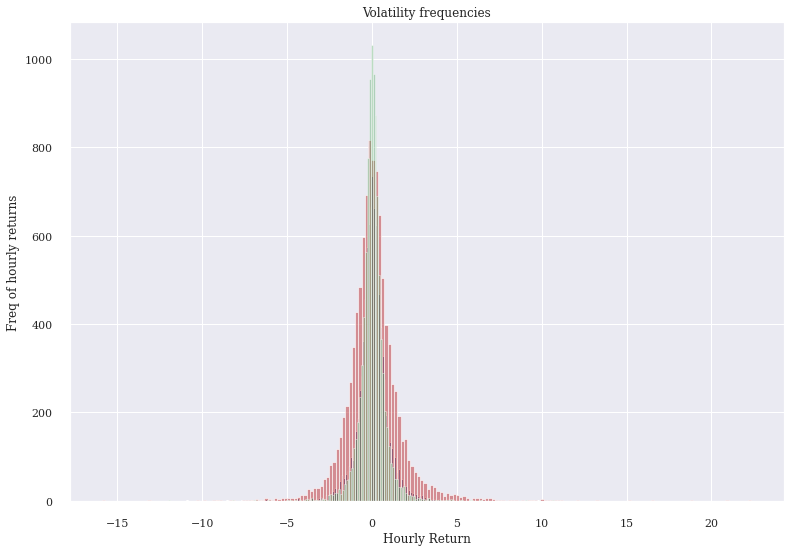

In [20]:
#hide_input
fig, ax = plt.subplots()
dataframe['ETH_hourly_Return'].hist(ax=ax, bins=200, alpha=1, color='b')
dataframe['LUNA_hourly_Return'].hist(ax=ax, bins=200, alpha=0.6, color='r')
dataframe['BTC_hourly_Return'].hist(ax=ax, bins=200, alpha=0.4, color='g')
ax.set_xlabel("Hourly Return")
ax.set_ylabel("Freq of hourly returns")
ax.set_title("Volatility frequencies")
plt.show()

#### Now let's look at what happened in early 2022

Previously, we looked at the data from the beginning of 2021 which of course shows the bigger picture but let's look at a time when a market down turn happened. On the other hand LUNA adopt more users in 2021 so, it became one of the "blue chip" assets very recently, getting in to top 10 in terms of market cap. therefore it would be fair to compare other assets with LUNA in 2022 rather than in 2021.

In [21]:
#hide
dataframe_2022 = dataframe[dataframe.index >= datetime(2022, 1, 1)]

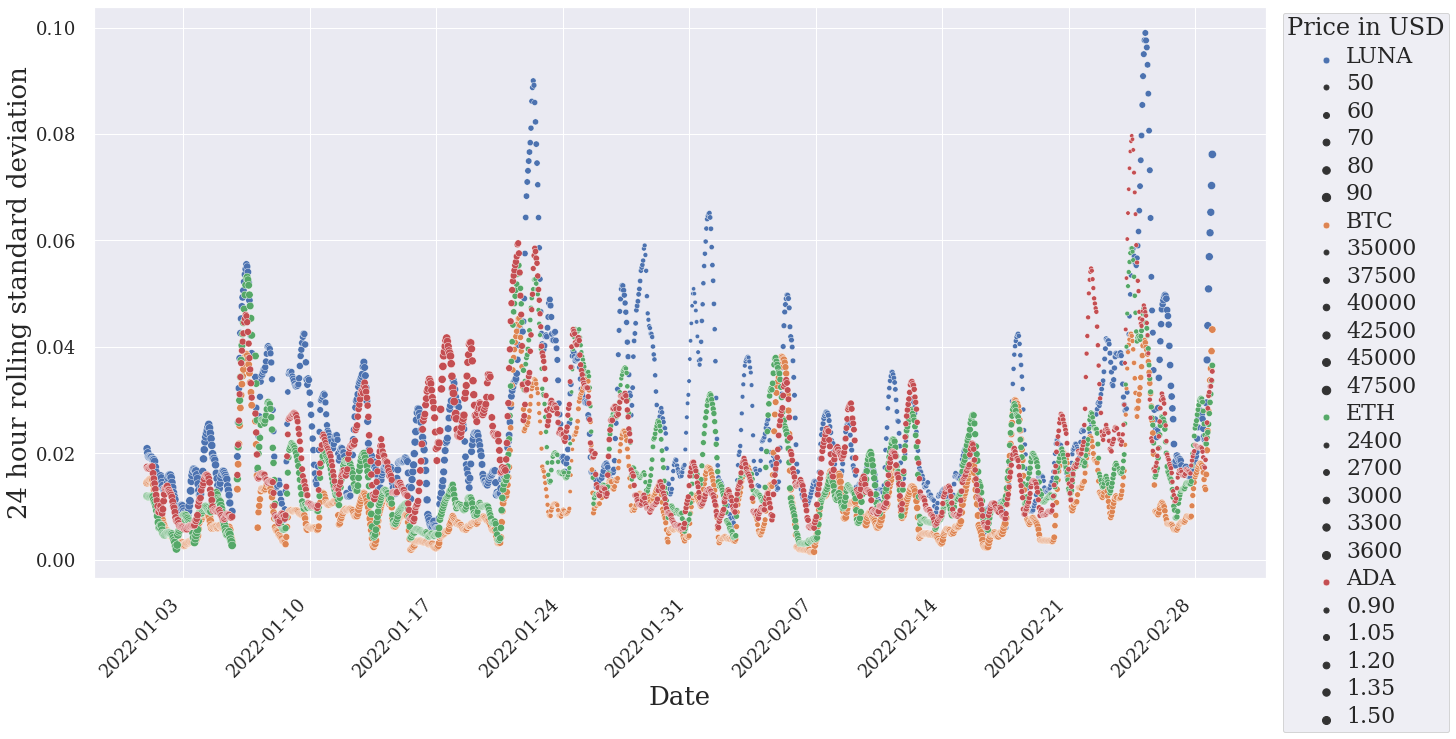

In [22]:
#hide_input
ax = sns.scatterplot(x=dataframe_2022.index, y=dataframe_2022.LUNA_1d_rolling, size=dataframe_2022.LUNA, label="LUNA")
sns.scatterplot(x=dataframe_2022.index, y=dataframe_2022.BTC_1d_rolling, size=dataframe_2022.BTC, ax=ax, label="BTC")
sns.scatterplot(x=dataframe_2022.index, y=dataframe_2022.ETH_1d_rolling, size=dataframe_2022.ETH, ax=ax, label="ETH")
sns.scatterplot(x=dataframe_2022.index, y=dataframe_2022.ADA_1d_rolling, size=dataframe_2022.ADA, ax=ax, label="ADA")
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 7))

show_fig(ax, "Date", "24 hour rolling standard deviation")

We can see LUNA has high volatile days in 2022 compared to others but in terms of price it seems to have appreciated specially in the latter part of February while early January had seen some price depreciation though the volatility wasn't significantly higher than the other 3 assets. (the size of the points represents the price)

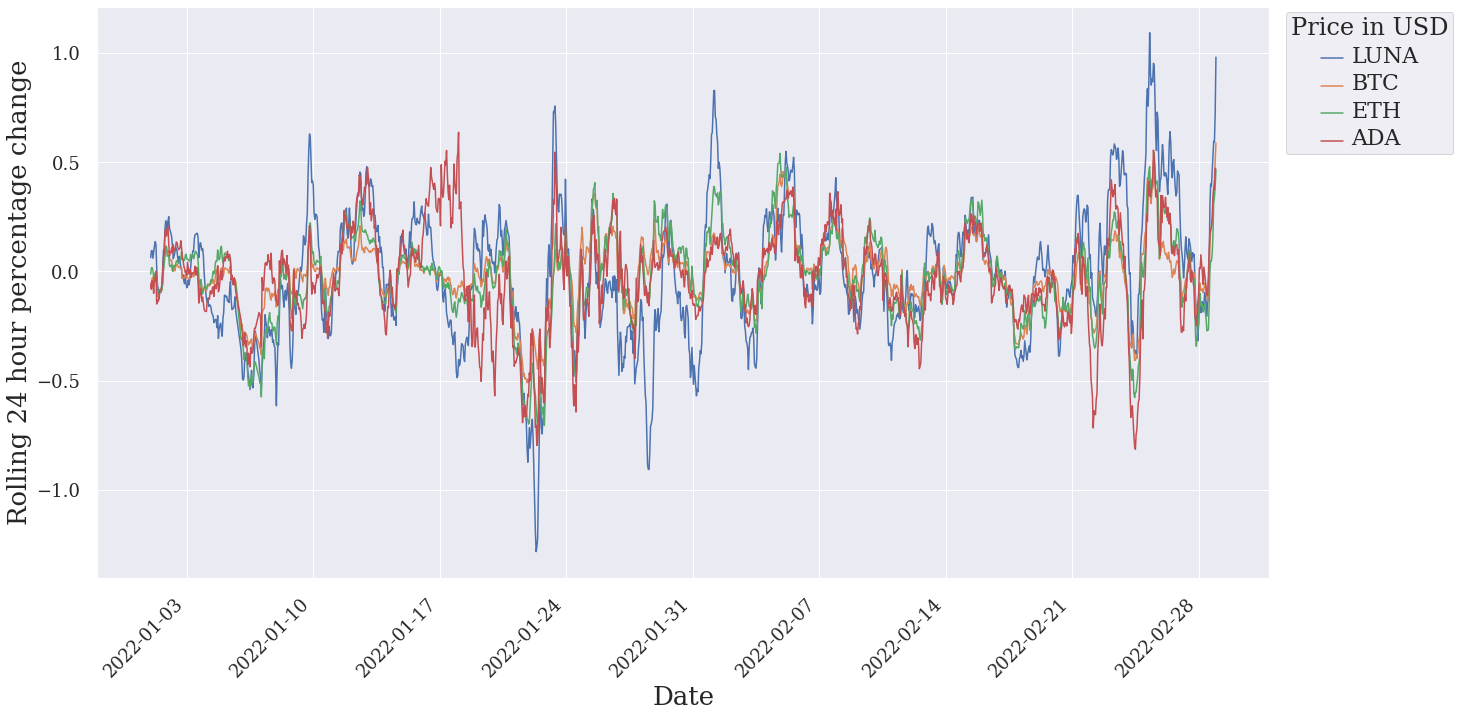

In [23]:
#hide_input
ax = sns.lineplot(x=dataframe_2022.index, y=dataframe_2022.LUNA_Return, label="LUNA")
sns.lineplot(x=dataframe_2022.index, y=dataframe_2022.BTC_Return, ax=ax, label="BTC")
sns.lineplot(x=dataframe_2022.index, y=dataframe_2022.ETH_Return, ax=ax, label="ETH")
sns.lineplot(x=dataframe_2022.index, y=dataframe_2022.ADA_Return, ax=ax, label="ADA")
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 7))

show_fig(ax, "Date", "Rolling 24 hour percentage change")

In [24]:
#hide
list_results = []
garch_model = arch_model(dataframe_2022['LUNA_hourly_Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
list_results.append(gm_result.params.rename("LUNA"))

garch_model = arch_model(dataframe_2022['ETH_hourly_Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
list_results.append(gm_result.params.rename("ETH"))

garch_model = arch_model(dataframe_2022['BTC_hourly_Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
list_results.append(gm_result.params.rename("BTC"))

garch_model = arch_model(dataframe_2022['ADA_hourly_Return'].dropna(), p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
list_results.append(gm_result.params.rename("ADA"))

In [25]:
#hide_input
pd.concat(list_results, axis=1)

,LUNA,ETH,BTC,ADA
mu,0.01907,0.03259,0.04419,-0.00404
omega,0.03919,0.13497,0.08001,0.01529
alpha[1],0.08771,0.33202,0.67515,0.04190
beta[1],0.88844,0.52006,0.32485,0.94673


In [26]:
#hide_input
pd.DataFrame(100 * (dataframe_2022.iloc[-1, :] - dataframe_2022.iloc[0, :]) / dataframe_2022.iloc[0, :]).transpose()[["ETH", "LUNA", "BTC", "ADA"]]

,ETH,LUNA,BTC,ADA
0,-21.45311,4.69122,-7.23561,-27.98558


Again we can see in 2022 LUNA's price difference was relatively better compared to other assets although it was volatile in both directions. we can look at a histogram to confrim that the daily volatility frequencies.

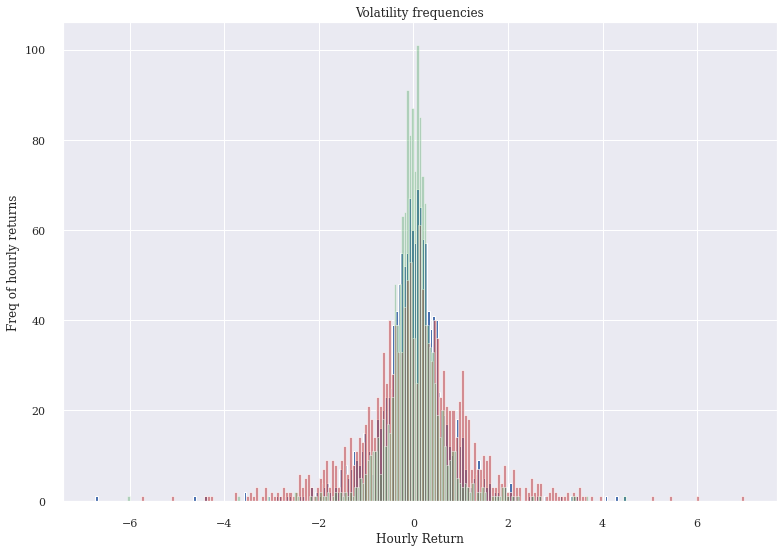

In [27]:
#hide_input
fig, ax = plt.subplots()
dataframe_2022['ETH_hourly_Return'].hist(ax=ax, bins=200, alpha=1, color='b')
dataframe_2022['LUNA_hourly_Return'].hist(ax=ax, bins=200, alpha=0.6, color='r')
dataframe_2022['BTC_hourly_Return'].hist(ax=ax, bins=200, alpha=0.4, color='g')
ax.set_xlabel("Hourly Return")
ax.set_ylabel("Freq of hourly returns")
ax.set_title("Volatility frequencies")
plt.show()

#### To Conclude:

- LUNA has it's high volatility nature in both directions
- But LUNA seems to have rewarded it's holders better as the price of the LUNA appreciated highly since 2021 and impacted the least in 2022 (among the 4 assets we compared)